## Домашнее задание «Элементарные методы анализа временных рядов»
Преподаватель: Даниил Корбут, Наталья Баданина

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель


In [184]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [202]:
car_sales = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")

In [203]:
car_sales.tail(3)

,Month,Count
105,1968-10,21342
106,1968-11,17180
107,1968-12,14577


In [210]:
stac_car_sales = boxcox(car_sales['Count'], 0)
car_sales['Stac_count'] = np.diff(stac_car_sales, 1, append=9.58)

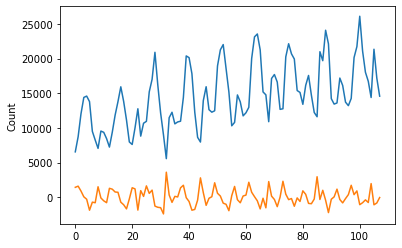

In [211]:
sns.lineplot(data=car_sales['Count']);
sns.lineplot(data=car_sales['Stac_count']*5000);

In [228]:
car_sales.tail()

,Month,Count,Stac_count
103,1968-08,16722,-0.150539
104,1968-09,14385,0.394491
105,1968-10,21342,-0.216931
106,1968-11,17180,-0.164301
107,1968-12,14577,-0.007200


In [213]:
train, val = car_sales['Count'][:65], car_sales['Count'][65:]

Для сырых значений применяем метод Хольт-Винтерса, здесь есть и тренд и сезонность

In [214]:
def plot_tema(alpha, beta, gamma, ser=car_sales["Count"], ser_to_plot=car_sales["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
        
def initial_trend(i, series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(i, series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [215]:
mse_cross_val([0.1217812 , 0.32826813, 0.79252237] )

7958574.113591176------------


7958574.113591176

In [216]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

/home/dmi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:534: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


54766491.30353024------------
54170773.17006575------------
54766491.30353024------------
54717370.132883646------------
54338478.1987922------------
54054208.01323906------------
53704842.312579------------
53439297.46090793------------
52823861.30653512------------
52795751.65663455------------
52046783.79110762------------
51598923.31544009------------
50407018.82230675------------
49904403.33069179------------
48191525.50794529------------
47727269.2580887------------
45496347.31558746------------
44508435.313521884------------
41589306.58347759------------
40480483.67371259------------
36925356.43657144------------
35840735.90964934------------
32149741.49683446------------
31136388.85494237------------
28290430.940570813------------
26972538.73941359------------
25379187.90604313------------
26108959.77173376------------
28220896.296144318------------
30368462.371207345------------
26243154.15580055------------
28481625.21828543------------
26484389.769246023------------
26375264

In [217]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt.x)

[0.13486136 0.06525784 0.56541454]


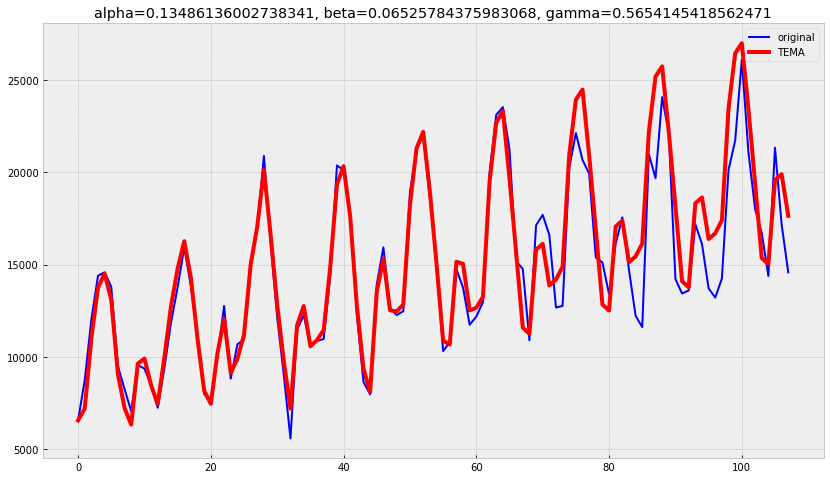

In [218]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=car_sales['Count'], n_preds=len(val))

In [219]:
train, val = car_sales['Stac_count'][:65], car_sales['Stac_count'][65:]
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

/home/dmi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:534: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


0.10025679139745376------------
0.09907331638244643------------
0.10025679139745376------------
0.10015779973875927------------
0.09940537662557457------------
0.0988410421016956------------
0.09814900604140103------------
0.09762601129531946------------
0.09641447885539561------------
0.09635809666920252------------
0.09488932714668928------------
0.0940149010131915------------
0.09170050009659249------------
0.09073165763545782------------
0.0874520228961182------------
0.08656625380934606------------
0.08236757228304233------------
0.08053803602325976------------
0.07520422833656326------------
0.07320685866297043------------
0.0669507009181831------------
0.06508246480721243------------
0.05888165812802609------------
0.0572342657976642------------
0.05271251556081211------------
0.05064689412286332------------
0.048398650871062925------------
0.04978330804138165------------
0.05420853452289607------------
0.05030865617948655------------
0.054141762858481914------------
0.049828100

In [220]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt.x)

[0.12272567 0.0006898  0.41958772]


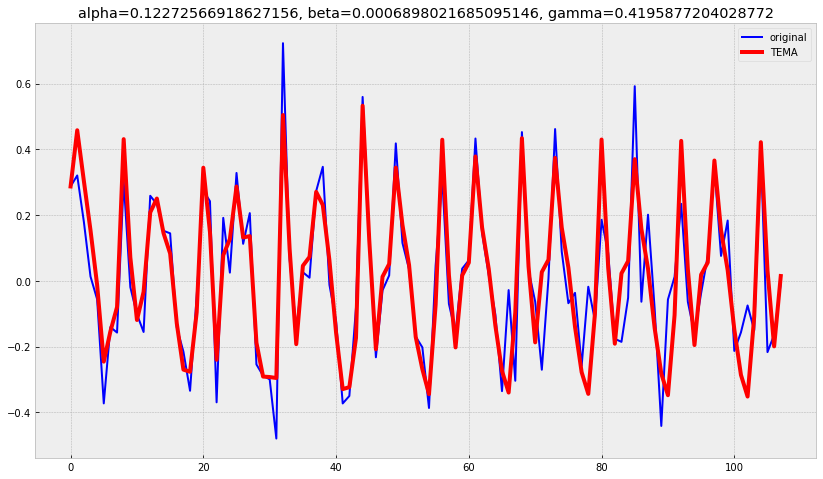

In [221]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=car_sales['Stac_count'], n_preds=len(val))

Для стационарного ряда также можно использовать метод Хольт-Винтерса, 

при этом в процессе оптимизации заначение бета стремится к нулю

Для стационарного ряда должны работать более простые модели, например экспоненциальное сглаживание, скользящее среднее, и тд

In [226]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma


def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

In [235]:
train, val = car_sales['Stac_count'][:80], car_sales['Stac_count'][80:]
ema = exponential_moving_average(train, 0.3, 27)
ema

(0      0.287071
 1      0.320535
 2      0.179810
 3      0.013250
 4     -0.056115
          ...   
 103   -0.054858
 104   -0.054858
 105   -0.054858
 106   -0.054858
 107   -0.054858
 Length: 108, dtype: float64,
 0      0.287071
 1      0.287071
 2      0.297110
 3      0.261920
 4      0.187319
          ...   
 102   -0.054858
 103   -0.054858
 104   -0.054858
 105   -0.054858
 106   -0.054858
 Length: 107, dtype: float64)

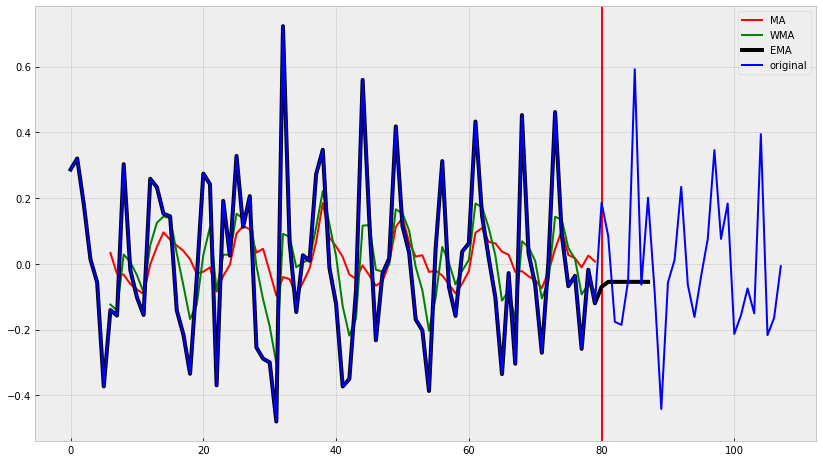

In [248]:
time_series = car_sales['Stac_count']
ema, _ = exponential_moving_average(train, 0.3, 7)
wma = weighted_moving_average(train, 7, [1,1,2,3,5,8,13])
ma = moving_average(train, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.axvline(80, color='r', linestyle='solid')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.plot(time_series, color='blue',label='original')

    plt.legend()

In [263]:
def mse_cross_val(alpha):
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        _, result = exponential_moving_average(train_split_ts, alpha, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [264]:
mse_cross_val(0.2)

0.07515490153727032------------


0.07515490153727032

In [265]:
opt = minimize(mse_cross_val, x0=0, method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

0.142240764637749------------
0.14075530845118864------------
0.13930210211928098------------
0.1378803796337836------------
0.13512841757180985------------
0.13249366900020976------------
0.1275542044683596------------
0.12302138442974564------------
0.11503234906717037------------
0.1082729553462967------------
0.09764956571105503------------
0.08989724213981437------------
0.07987966440391878------------
0.0741604640439614------------
0.06877298629508706------------
0.06696498127149479------------
0.06716692186759794------------
0.06668929897011701------------
0.06716692186759794------------
0.06669925710692391------------
0.0668618715895935------------
0.06666755742161845------------
0.06669925710692391------------
0.06667229469119658------------
0.06667615299690903------------
0.06666832848781454------------
0.06667011785394159------------
0.06666753519576903------------
0.06666832848781454------------
0.0666674433007275------------
0.06666755742161845------------
0.06666746363080

/home/dmi/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:534: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


In [266]:
alpha_opt = opt.x
print(opt.x)

[0.076]


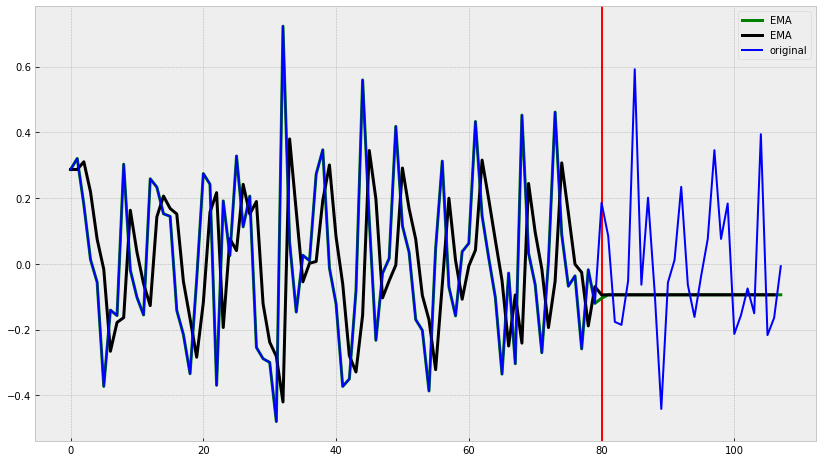

In [272]:
time_series = car_sales['Stac_count']
ema, _ = exponential_moving_average(train, 0.7, 27)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.axvline(80, color='r', linestyle='solid')
    plt.plot(ema, color='green', linewidth='3', label='EMA')
    plt.plot(_, color='black', linewidth='3', label='EMA')
    plt.plot(time_series, color='blue',label='original')

    plt.legend()

In [275]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

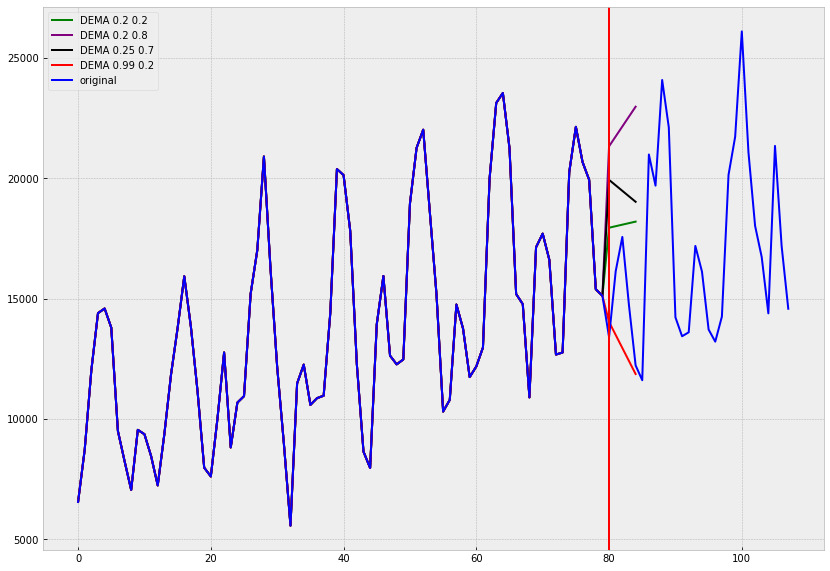

In [303]:
train, val = car_sales['Count'][:80], car_sales['Count'][80:]

alphas = [0.2,0.2,0.25,0.99]
bettas = [0.2,0.8,0.7,0.2]
colors = ['green', 'purple', 'black','red']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 10))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(train, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(car_sales['Count'], color='blue',label='original')
    plt.axvline(80, color='r', linestyle='solid')

    plt.legend()

Используя методы скользящего среднего, экспоненциального сглаживания, двойного экспонтенциального сглаживания довольно сложно получить модели с высокой предсказательной способностью.

Наибольшей предсказательной способностью, для данного временного ряда, обладает 
метод Хольта-Винтерса.

Это обьясняется тем, что модели тройного экспоненциального сглаживания хорошо работают с данными в которых есть сезонность